In [1]:
#Import librairies
import cv2
import dlib 
import numpy as np
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import json
from collections.abc import Mapping
from torchvision.transforms import v2
import pandas as pd
# from image_segmentation import *
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

In [2]:
file_name = r"./coin-detector-model/coin-detector-2.svm"
detector = dlib.simple_object_detector(file_name)

  0%|          | 0/3 [00:00<?, ?it/s]

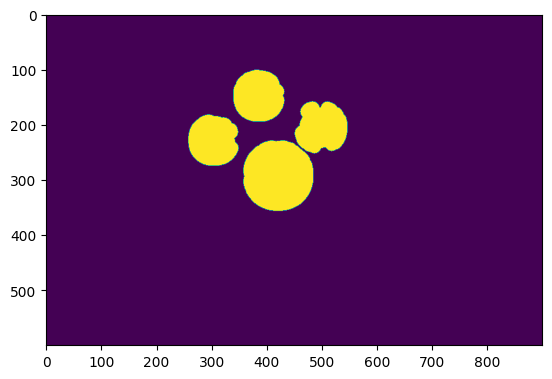

 33%|███▎      | 1/3 [00:03<00:07,  3.57s/it]

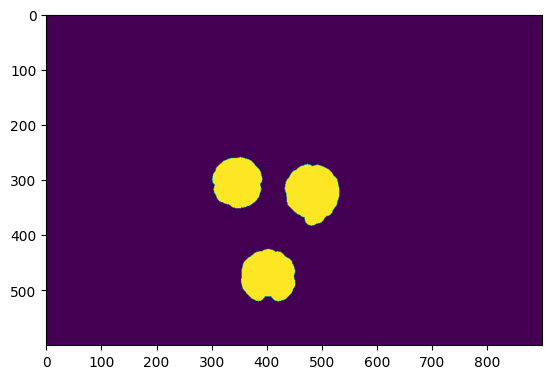

 67%|██████▋   | 2/3 [00:06<00:03,  3.40s/it]

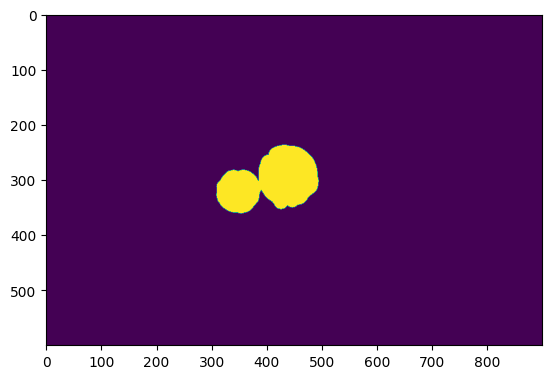

100%|██████████| 3/3 [00:10<00:00,  3.39s/it]


In [20]:
from skimage import morphology
from skimage import filters
import skimage
from skimage import feature
from skimage.transform import rescale, resize, downscale_local_mean
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import data, feature, exposure
from skimage import segmentation

possible_value = ["5CHF", "2CHF", "1CHF", "0.5CHF", "0.2CHF", "0.1CHF", "0.05CHF", "2EUR", "1EUR", "0.5EUR", "0.2EUR", "0.1EUR", "0.05EUR", "0.02EUR", "0.01EUR", "OOD"]
test_folder = r"./data/test"
valid_extensions = ('.jpg')
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
model = torch.load(r"./model/best_model.pth", map_location=device)
model.eval()

file_list = os.listdir(test_folder)
image_files = [f for f in file_list if f.lower().endswith(valid_extensions)]
image_files = [r"./data/train/all/L1010405.JPG", r"./data/train/all/L1010462.JPG", r"./data/train/all/L1010506.JPG"]
for image_file in tqdm(image_files):
    answer = {}
    coins = []
    image = cv2.imread(image_file)
    image_name = image_file.removesuffix(".JPG")
    if image is None:
        print(f"Failed to load {image_file}")
        continue
    res = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    h = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,0]
    h = rescale(h, 0.30, anti_aliasing=False)
    h = h < 0.085
    res = rescale(res, 0.30, anti_aliasing=False)
    s = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)[:,:,2]
    s = rescale(s, 0.30, anti_aliasing=False)
    s = s > 0.070
    res = feature.canny(res, sigma=1)
    res = np.logical_and(res,h)
    res = np.logical_and(res,s)
    res = rescale(res, 0.50, anti_aliasing=False)
    res = morphology.dilation(res, footprint=morphology.square(9))
    res = morphology.area_closing(res, 10_000)
    res = morphology.area_opening(res, area_threshold=5000)
    res = morphology.erosion(res, footprint=morphology.disk(12))
    res = morphology.remove_small_objects(res, 1000)
    res = morphology.dilation(res, footprint=morphology.disk(12))
    plt.imshow(res)
    plt.show()


In [ ]:
possible_value = ["5CHF", "2CHF", "1CHF", "0.5CHF", "0.2CHF", "0.1CHF", "0.05CHF", "2EUR", "1EUR", "0.5EUR", "0.2EUR", "0.1EUR", "0.05EUR", "0.02EUR", "0.01EUR", "OOD"]
test_folder = r"./data/test"
valid_extensions = ('.jpg')
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
model = torch.load(r"./model/best_model.pth", map_location=device)
model.eval()

file_list = os.listdir(test_folder)
image_files = [f for f in file_list if f.lower().endswith(valid_extensions)]

final_count = []

image_files = sorted(image_files)

for image_file in tqdm(image_files):
    answer = {}
    coins = []
    image_path = os.path.join(test_folder, image_file)
    image = cv2.imread(image_path)
    image_name = image_file.removesuffix(".JPG")
    if image is None:
        print(f"Failed to load {image_file}")
        continue
    
    detected_im = detector(image)
    for i, detect_test in enumerate(detected_im):
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        d_box = detect_test
        coins.append(img_rgb[d_box.top():d_box.bottom(), d_box.left():d_box.right()])
    coin_count = {}
    answer["id"] = image_name
    for i in range(16):
        answer[possible_value[i]] = 0

    for c in coins:
        if(c.shape[0] == 0 or c.shape[1] == 0):
            continue
        c = torch.tensor(c, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        transform = v2.Compose([
            v2.Resize(224),
            v2.CenterCrop(224),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        with torch.no_grad():
            c = transform(c)
            output = model(c)
            res = output.argmax()
            answer[possible_value[res.item()]] += 1
    final_count.append(answer)

print("Creating csv file...")

pandas_df = pd.DataFrame(final_count)
pandas_df.to_csv(r"./data/test-predictions.csv", index=False)



  0%|          | 0/162 [00:00<?, ?it/s]/home/bluedrack/.conda/envs/iapr/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 162/162 [07:31<00:00,  2.78s/it]

Creating csv file...
[{'id': 'L0000000', '5CHF': 0, '2CHF': 0, '1CHF': 0, '0.5CHF': 2, '0.2CHF': 0, '0.1CHF': 0, '0.05CHF': 0, '2EUR': 0, '1EUR': 0, '0.5EUR': 0, '0.2EUR': 0, '0.1EUR': 0, '0.05EUR': 0, '0.02EUR': 0, '0.01EUR': 0, 'OOD': 1}, {'id': 'L0000001', '5CHF': 0, '2CHF': 0, '1CHF': 0, '0.5CHF': 0, '0.2CHF': 0, '0.1CHF': 0, '0.05CHF': 0, '2EUR': 0, '1EUR': 0, '0.5EUR': 0, '0.2EUR': 0, '0.1EUR': 0, '0.05EUR': 0, '0.02EUR': 0, '0.01EUR': 0, 'OOD': 10}, {'id': 'L0000002', '5CHF': 0, '2CHF': 0, '1CHF': 0, '0.5CHF': 1, '0.2CHF': 0, '0.1CHF': 0, '0.05CHF': 0, '2EUR': 0, '1EUR': 0, '0.5EUR': 0, '0.2EUR': 0, '0.1EUR': 0, '0.05EUR': 0, '0.02EUR': 0, '0.01EUR': 0, 'OOD': 3}, {'id': 'L0000003', '5CHF': 0, '2CHF': 0, '1CHF': 0, '0.5CHF': 3, '0.2CHF': 0, '0.1CHF': 0, '0.05CHF': 0, '2EUR': 0, '1EUR': 0, '0.5EUR': 0, '0.2EUR': 0, '0.1EUR': 0, '0.05EUR': 0, '0.02EUR': 0, '0.01EUR': 0, 'OOD': 5}, {'id': 'L0000004', '5CHF': 0, '2CHF': 0, '1CHF': 0, '0.5CHF': 1, '0.2CHF': 0, '0.1CHF': 0, '0.05CHF':

In [ ]:
# Compare prediction with labels
labels = pd.read_csv(r"./data/train_labels.csv")
#labels = labels.sort_values(by="id")
predictions = pd.read_csv(r"./data/train-predictions.csv")
#predictions = predictions.sort_values(by="id")
diff = labels.compare(predictions)
print(diff)

          id           5CHF       2CHF       1CHF       0.5CHF        ...  \
        self     other self other self other self other   self other  ...   
0   L1010281  L1010277  NaN   NaN  NaN   NaN  NaN   NaN    0.0   2.0  ...   
1   L1010298  L1010279  NaN   NaN  2.0   0.0  1.0   0.0    2.0   1.0  ...   
2   L1010321  L1010281  NaN   NaN  NaN   NaN  1.0   0.0    2.0   1.0  ...   
3   L1010310  L1010283  NaN   NaN  NaN   NaN  1.0   0.0    1.0   0.0  ...   
4   L1010300  L1010287  NaN   NaN  1.0   0.0  NaN   NaN    0.0   2.0  ...   
..       ...       ...  ...   ...  ...   ...  ...   ...    ...   ...  ...   
76  L1010524  L1010515  1.0   0.0  NaN   NaN  NaN   NaN    NaN   NaN  ...   
77  L1010506  L1010517  1.0   0.0  NaN   NaN  NaN   NaN    0.0   1.0  ...   
78       NaN       NaN  1.0   0.0  NaN   NaN  NaN   NaN    0.0   1.0  ...   
79  L1010515  L1010523  NaN   NaN  NaN   NaN  NaN   NaN    NaN   NaN  ...   
80  L1010523  L1010524  NaN   NaN  NaN   NaN  NaN   NaN    NaN   NaN  ...   